In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json

In [2]:
%reload_ext autoreload
%autoreload 2

# EDA

Set a predetermined seed so all our results can be replicated

In [3]:
RANDOM_SEED = 1337

Original data downloaded from: https://www.kaggle.com/datasets/abhinav89/telecom-customer?resource=download. <br />
Data can be cleaned by running clean_raw.py in the repository to get the data into the form used in this notebook. <br/>

In [4]:
full_data = pd.read_csv('Dataset/clean_data.csv', index_col='Customer_ID')

- Data contains 100,000 rows and 99 features
- Customer_ID serves as the primary key for each customer 
- Target variable is 'churn' where
    -  1 = Customer Churned
    -  0 = Customer Stayed

In [4]:
full_data.shape

(100000, 99)

In [5]:
full_data.head(5)

,actvsubs,adjmou,adjqty,adjrev,adults,area,asl_flag,attempt_mean,avg3mou,avg3qty,...,threeway_mean,totcalls,totmou,totmrc_mean,totrev,truck,unan_dat_mean,unan_vce_mean,uniqsubs,vceovr_mean
Customer_ID,,,,,,,,,,,,,,,,,,,,,
1000001,1,4085.00,1602,1453.44,1.0,NORTHWEST/ROCKY MOUNTAIN AREA,0,52.333333,272,116,...,0.000000,1652,4228.00000,22.500,1504.62,0.0,0.0,6.333333,2,0.0
1000002,1,26367.00,14624,2833.88,1.0,CHICAGO AREA,0,263.333333,305,158,...,0.333333,14654,26400.00000,37.425,2851.68,1.0,0.0,61.333333,1,9.1
1000003,1,24303.05,7888,1934.47,2.0,GREAT LAKES AREA,0,9.000000,12,7,...,0.000000,7903,24385.05333,16.990,2155.91,0.0,0.0,2.666667,1,0.0
1000004,1,3035.00,1479,1941.81,4.0,CHICAGO AREA,0,3.666667,8,3,...,0.000000,1502,3065.00000,38.000,2000.90,0.0,0.0,0.000000,1,0.0
1000005,1,13965.00,4452,2166.48,1.0,NEW ENGLAND AREA,0,222.333333,558,191,...,0.000000,4485,14028.00000,71.980,2181.12,0.0,0.0,77.000000,1,0.0


In [19]:
#Column descriptions are scraped from the kaggle website via beautifulsoup. 
#It's been packaged in this repository for convenience's sake. 
with open('columnDescriptions.json','r') as f:
    col_desc = json.load(f)

In [16]:

col_desc = pd.read_json('columnDescriptions.json',orient='index')[0].rename('col_desc').to_frame()



Our target variable in the data is surprisingly well balanced to begin with. We might still input some weights when building the model later just to make sure but this hopefully means detecting positive cases (churned customers) much easier. 

<AxesSubplot:xlabel='churn', ylabel='count'>

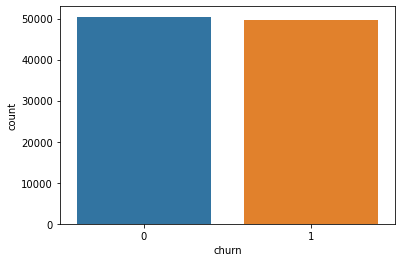

In [6]:
sns.countplot(x=full_data.churn)

Some of the columns within our data cannot be reliably imputed by our preprocessing, hence there are some columns still with missing data as seen below. We're hoping to use algorithms that can handle missing data since some of it may be MNAR with a lot of rows missing, but we'll take other steps to address the missingness if need be later. 

Text(0.5, 1.0, '% Data Missing in Each Column')

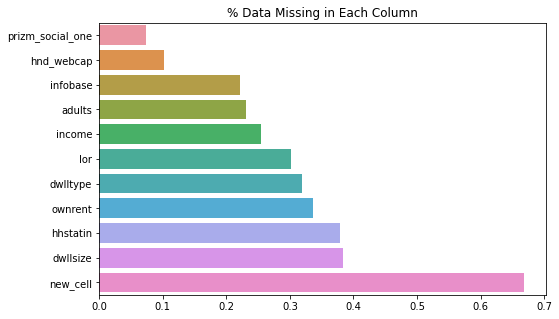

In [7]:
miss_data_cols = full_data.columns[full_data.isna().sum()>0]
pct_miss_data = (
    full_data[miss_data_cols].isna().sum()
    .sort_values()
    /full_data.shape[0]
)
plt.figure(figsize=(8,5))
ax = sns.barplot(x=pct_miss_data,y=pct_miss_data.index)
ax.set_title('% Data Missing in Each Column')

# Univariate Analysis

In [5]:
cat_cols = full_data.select_dtypes(include='object').columns
num_cols = full_data.select_dtypes(include=np.number).columns
bin_cols = num_cols[full_data[num_cols].nunique()==2]
num_cols = pd.Index(set(num_cols)-set(bin_cols))


## Categorical Features

In [6]:
from graph_utils import get_subplot_dim

In [51]:
full_data[cat_cols].head(5)

,area,crclscod,dualband,dwllsize,ethnic,hhstatin,hnd_webcap,marital,prizm_social_one
Customer_ID,,,,,,,,,
1000001,NORTHWEST/ROCKY MOUNTAIN AREA,A,Y,A,N,C,WCMB,S,S
1000002,CHICAGO AREA,EA,N,A,Z,C,WC,S,U
1000003,GREAT LAKES AREA,C,N,A,N,C,NaN,M,S
1000004,CHICAGO AREA,B,N,D,U,C,NaN,M,T
1000005,NEW ENGLAND AREA,A,Y,O,I,C,WCMB,S,U


### Categorical Feature Distribution

<AxesSubplot:xlabel='count', ylabel='area'>

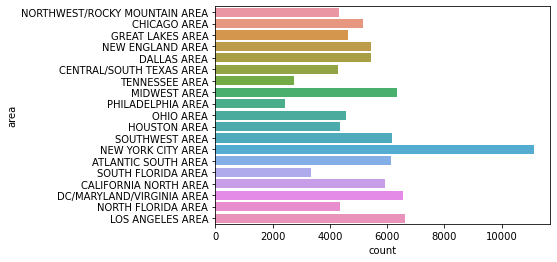

In [7]:
sns.countplot(y=full_data['area'])

<AxesSubplot:xlabel='count', ylabel='dualband'>

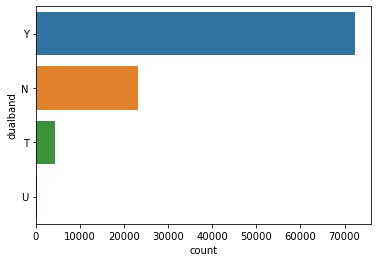

In [14]:
sns.countplot(y=full_data['dualband'])

In [13]:
full_data['crclscod'].value_counts().head(10)

AA    36509
A     16996
BA    12667
CA     8334
EA     6419
B      4110
DA     3669
ZA     3493
C      1456
A2      861
Name: crclscod, dtype: int64

<AxesSubplot:xlabel='count', ylabel='crclscod'>

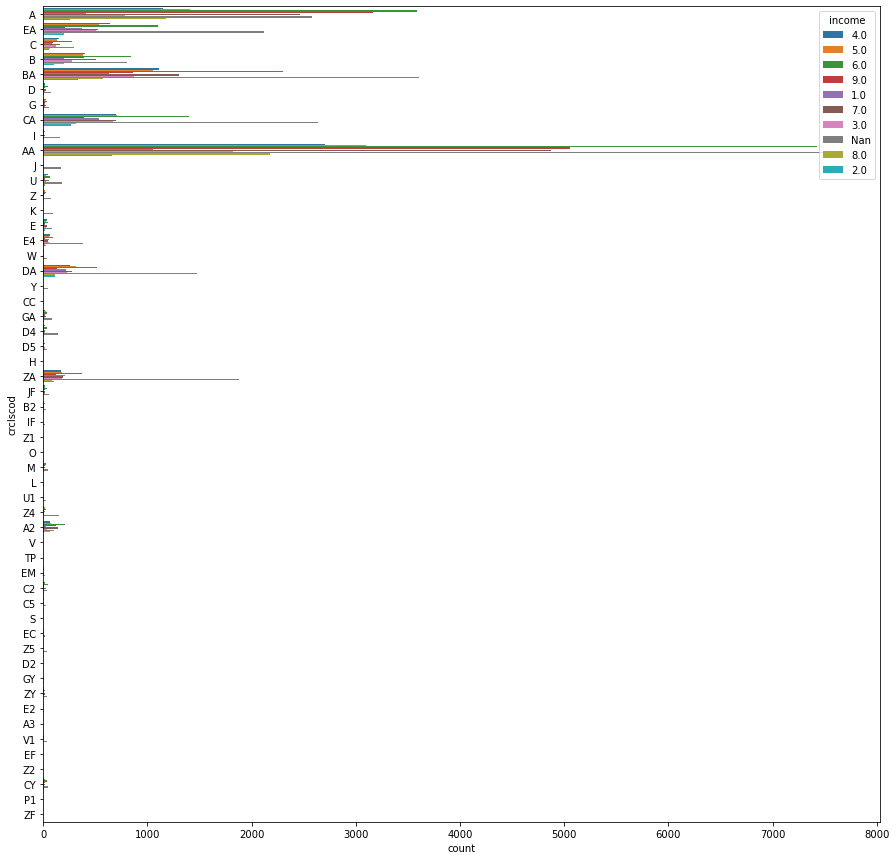

In [12]:
plt.figure(figsize=(15,15))
sns.countplot(
    data=full_data[['crclscod','income']].fillna('Nan'),
    y='crclscod',
    hue='income'
)